In [1]:
from lottery import *
from threading import Thread
from pid import *
import os

# controller gains search space simulation.  

## simulation parameters

In [2]:
AVG_LEN = 5

KP_STEP=0.05
KP_SEARCH_START=-0.1
KP_SEARCH_END=0.3

KI_STEP=0.05
KI_SEARCH_START=-0.1
KI_SEARCH_END=0.1

KD_STEP=0.05
KD_SEARCH_START=-0.2
KD_SEARCH_END=0.1

EPSILON=0.0001
RUNNING_TIME=1000

#AIRDROP=1000
NODES=100000

In [6]:
randomize_nodes_str = input("randomize number of nodes (y/n):")
randomize_nodes = True if randomize_nodes_str.lower()=="y" else False

rand_running_time_str = input("random running time (y/n):")
rand_running_time = True if rand_running_time_str.lower()=="y" else False

debug_str = input("debug mode (y/n):")
debug = True if debug_str.lower()=="y" else False

randomize number of nodes (y/n):y
random running time (y/n):y
debug mode (y/n):n


In [10]:
def experiment(accs, controller_type=CONTROLLER_TYPE_DISCRETE, kp=0, ki=0, kd=0, airdrop=0):
    dt = DarkfiTable(0, RUNNING_TIME, controller_type, kp=kp, ki=ki, kd=kd)
    RND_NODES = random.randint(5, NODES) if randomize_nodes else NODES
    for idx in range(0,RND_NODES):
        darkie = Darkie(airdrop)
        dt.add_darkie(darkie)
    acc = dt.background(rand_running_time)
    accs+=[acc]
    return acc

## note! skip the cell below, it will take many hours, and large space dpending on the search space range above.

In [ ]:
accuracy = []
if __name__ == "__main__":
    # kp
    for kp in tqdm(np.arange(KP_SEARCH_START, KP_SEARCH_END, KP_STEP)):
        # ki
        for ki in np.arange(KI_SEARCH_START, KI_SEARCH_END, KI_STEP):
            # kd
            for kd in np.arange(KD_SEARCH_START, KD_SEARCH_END, KD_STEP):
                target = 1
                experiment_accs = []
                exp_threads = []
                for i in range(0, AVG_LEN):
                    exp_thread = Thread(target=experiment, args=[experiment_accs, CONTROLLER_TYPE_DISCRETE, kp, ki, kd])
                    exp_thread.start()
                for thread in exp_threads:
                    thread.join()
                avg_acc = sum(experiment_accs)/float(AVG_LEN)
                gains = (avg_acc, (kp, ki, kd))
                accuracy+=[gains]
    accuracy=sorted(accuracy, key=lambda i: i[0], reverse=True)
    with open("gains.txt", "w") as f:
        buff=''
        for gain in accuracy:
            line=str(gain[0])+',' +','.join([str(i) for i in gain[1]])+'\n'
            buff+=line
            f.write(buff)


  0%|                                                                                                                                                                                       | 0/4 [00:00<?, ?it/s]

random running time: 906
random running time: 579
random running time: 283
random running time: 869
random running time: 946
random running time: 727
random running time: 256
random running time: 144
random running time: 297
random running time: 310
random running time: 557
random running time: 10
random running time: 753
random running time: 958
random running time: 608
random running time: 531
random running time: 968
random running time: 44
random running time: 418
random running time: 268
random running time: 849
random running time: 844
random running time: 304
random running time: 745
random running time: 160
random running time: 891
random running time: 625
random running time: 452
random running time: 349
random running time: 186
random running time: 877
random running time: 897
random running time: 722
random running time: 691
random running time: 969
random running time: 350
random running time: 824
random running time: 52
random running time: 418
random running time: 233
ran

# controller parameters results


the controller results shows that optimal gains are as follows:
kp=0.18, ki=0.02, kd=-0.1,

In [3]:
def instance(kp, ki, kd, nodes, initial_distribution):
    os.system("rm f.hist; rm leads.hist")
    RUNNING_TIME = int(input("running time (slots):"))

    if __name__ == "__main__":
        darkies = []
        darkies += [Darkie(initial_distribution[id]) for id in range(nodes)]
        airdrop = 0
        for darkie in darkies:
            airdrop+=darkie.stake
        print("network airdrop: {} on {} nodes".format(airdrop, len(darkies)))
        dt = DarkfiTable(airdrop, RUNNING_TIME, CONTROLLER_TYPE_DISCRETE, kp=kp, ki=ki, kd=kd)
        for darkie in darkies:
            dt.add_darkie(darkie)
        dt.background(rand_running_time=False)
        dt.write()


# run lottery instance

In [4]:
def draw():
    LEAD_FILE = "leads.hist"
    F_FILE = "f.hist"

    LEAD_PROCESSED_IMG = "lead_history_processed.png"
    F_PROCESSED_IMG = "f_history_processed.png"

    SEP = ","
    NODES = 5 # nuber of nodes logged

    with open(LEAD_FILE) as f:
        buf = f.read()
        nodes = buf.split(SEP)[:-1]
        node_log = []
        for i in range(0, len(nodes)):
            node_log+=[int(nodes[i])]
        freq_single_lead = sum(np.array(node_log)==1)/float(len(node_log))
        print("single leader frequency: {}".format(freq_single_lead))
        plt.plot(node_log)
        plt.legend(['#leads'])
        plt.savefig(LEAD_PROCESSED_IMG)


    with open(F_FILE) as f:
        buf = f.read()
        nodes = buf.split(SEP)[:-1]
        node_log = []
        for i in range(0, len(nodes)):
            node_log+=[float(nodes[i])]
        plt.plot(node_log)
        plt.legend(['#leads', 'f'])
        plt.savefig(F_PROCESSED_IMG)

running time (slots):1000
network airdrop: 0 on 10000 nodes
random running time: 1000
pid per slot: 0:00:00.000017.
spin off per slot: 0:00:01.174686.
thread work per slot: 0:00:00.024469.
finalization per slot: 0:00:00.000003.
restart per slot: 0:00:00.052790.
total time: 0:20:51.981258, slot time: 0:00:01.251981
single leader frequency: 0.0


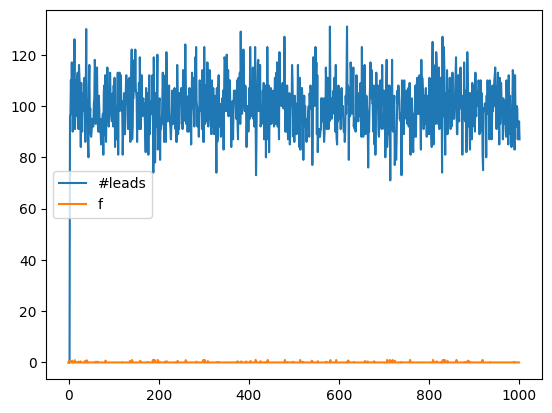

In [5]:
nodes = 10000
# stakers intial distribution
genesis_distribution = [0 for _ in range(nodes)]
# using simulation output
kp=0.18
ki=0.02
kd=-0.1
instance(kp, ki, kd, nodes, genesis_distribution)
draw()